In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from matplotlib.gridspec import GridSpec


In [3]:
df = pd.read_csv('cleaned_data.csv')
df.head()

,Price,Area,Bedrooms,Toilets,Published At,Loại tin,Status,Developer,Street,District,Suggested Price,Million/m2,District Price,Street Price
0,7.50,85.0,4,6,2024-10-24,Tin thường,Đã bàn giao,cá nhân/môi giới,1,bình chánh,107.1,88.24,4.500,15.25
1,23.00,230.0,5,6,2024-10-24,Tin thường,Đã bàn giao,cá nhân/môi giới,1,bình chánh,107.1,100.00,4.500,15.25
2,4.99,52.0,3,2,2024-10-25,Tin thường,Đã bàn giao,cá nhân/môi giới,1,bình tân,98.8,95.96,5.225,4.85
3,4.25,46.0,2,2,2024-10-28,Tin thường,Đã bàn giao,cá nhân/môi giới,1,bình tân,98.8,92.39,5.225,4.85
4,4.85,67.0,3,2,2024-10-25,Tin thường,Đã bàn giao,cá nhân/môi giới,1,bình tân,98.8,72.39,5.225,4.85


# B. EDA - Khám phá dữ liệu

## I. Các thống kê về số lượng bất động sản

### 1. Thống kê về tổng số lượng bất động sản được rao bán của từng quận/huyện

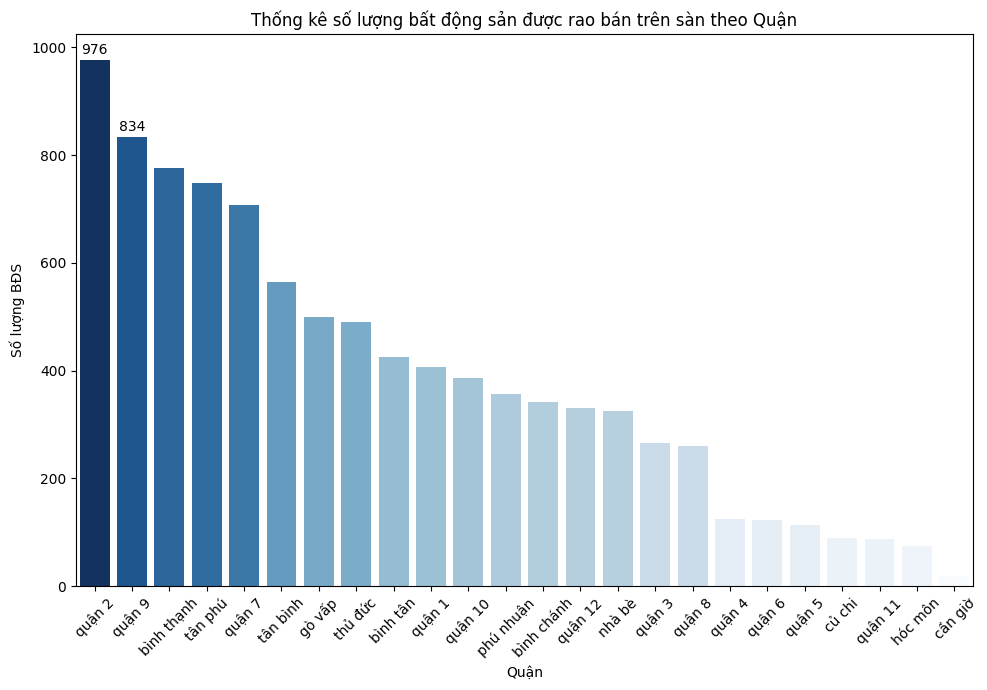

In [4]:
# Đếm số lượng BĐS trong mỗi quận
district_counts = df['District'].value_counts().reset_index()
district_counts.columns = ['District', 'Number of Properties']

# Xử lý để colormap
norm = plt.Normalize(min(district_counts["Number of Properties"]), max(district_counts["Number of Properties"])) # Chuaarn hoas duwx lieeuj
colors = list(cm.Blues(norm(district_counts["Number of Properties"])))  # Ánh xạ dữ liệu vào hệ màu Blues, palette không hỗ trợ numpy array
                                                                # nên phải chuyển sang list

# Vẽ biểu đồ với seaborn
plt.figure(figsize=(10, 7))
ax = sns.barplot(data=district_counts, x='District', y='Number of Properties', palette=colors, hue='District', legend=False)

# Thêm số lên cột
for i, p in enumerate(ax.patches):
    if district_counts['Number of Properties'][i] >= 800:  # Điều kiện
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 7), textcoords='offset points', fontsize=10)
    
plt.title('Thống kê số lượng bất động sản được rao bán trên sàn theo Quận')
plt.xlabel('Quận')
plt.ylabel('Số lượng BĐS')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Nhận xét:**
- Dựa vào thống kê, chúng ta dễ dàng nhận ra các quận trung tâm như quận 2, 7, 9, Bình Thạnh là các các quận có thị trường bất động sản sôi nổi nhất khu vực thành phố Hồ Chí Minh khi có từ hơn 600 đến gần 1000 bất động sản được rao bán trong từng quận. 

- Mặt khác, các quận/huyện ngoài rìa như huyện Hóc Môn, Cần Giờ, Củ Chi, Quận 11 là các quận ảm đạm về thị trường bất động sản nhất khi chỉ có dưới 200 bất động sản được đang bán trong thời gian của dữ liệu đăng bán.

- Dễ dàng nhận thấy chính sách thành lập thành phố Thủ Đức trực thuộc thành phố Hồ Chí Minh mang lại những tín hiệu tích cực rõ rệt trên thị trường bất động sản khi cả 3 quận thành viên của thành phố Thủ Đức lần lượt đều đứng top đầu trong số các quận có nhiều bất động sản được đăng bán nhất, cụ thể:
    - Quận 2 với 976 BDS (top 1)
    - Quận 9 với 834 BDS (top 2)
    - Quận Thủ Đức với gần 600 BDS (top 8)

*Ghi chú: Dữ liệu được thu thập từ 27/09/24 đến 31/10/24 tại trang web batdongsan.com*

### 2. Thống kê số lượng bất động sản được rao bán theo thời gian thống kê

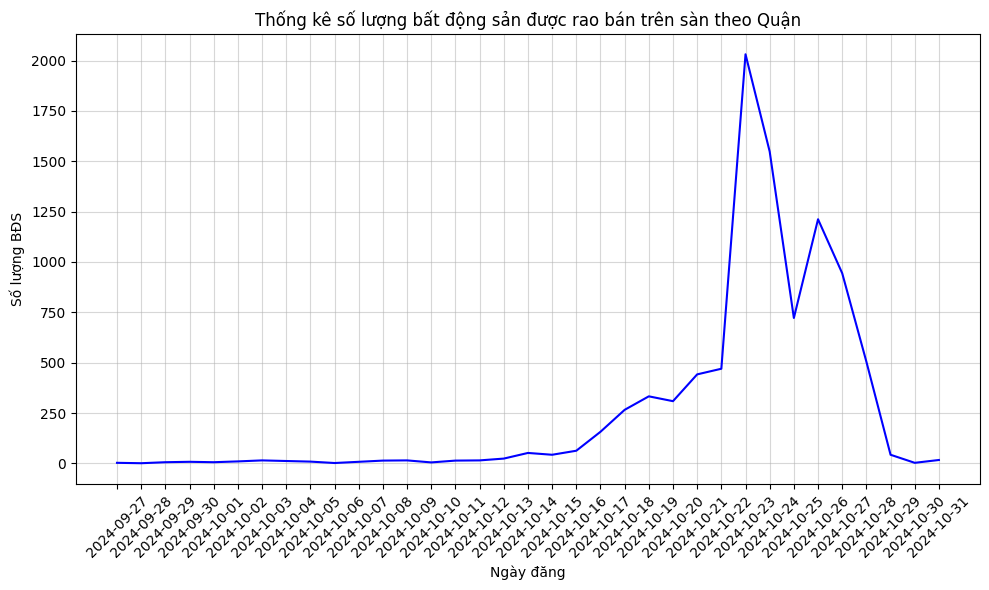

In [5]:
# Đếm số lượng BĐS trong mỗi quận
date_counts = df['Published At'].value_counts().reset_index()
date_counts.columns = ['Published At', 'Number of Properties']

# Sắp xếp dữ liệu theo ngày
date_counts = date_counts.sort_values(by='Published At')

# Vẽ biểu đồ với seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=date_counts, x='Published At', y='Number of Properties', color="blue")
plt.title('Thống kê số lượng bất động sản được rao bán trên sàn theo Quận')
plt.xlabel('Ngày đăng')
plt.ylabel('Số lượng BĐS')
plt.xticks(rotation=45)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

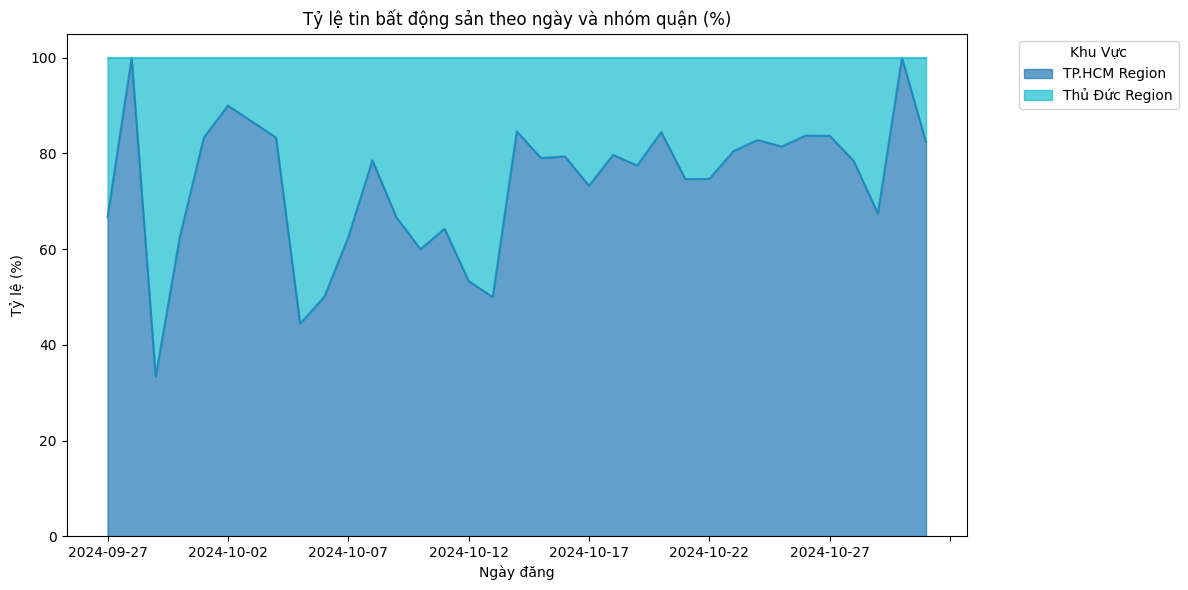

In [6]:
# Danh sách các quận chính
main_districts = [
    "quận 1", "quận 2", "quận 7", "quận 9", 
    "bình thạnh", "thủ đức", 
    "tân bình", "tân phú"
]

# Danh sách quận thuộc khu vực Thủ Đức
thu_duc_districts = ["quận 2", "quận 9", "quận thủ đức"]

# Gộp nhóm các khu vực
df["Region"] = df["District"].apply(
    lambda x: "Thủ Đức Region" if x in thu_duc_districts else "TP.HCM Region"
)

# Gom nhóm theo "Ngày đăng" và "Nhóm quận", đếm số lượng tin bất động sản
grouped_data = df.groupby(["Published At", "Region"]).size().reset_index(name="Quanity")

# Pivot table để chuẩn bị dữ liệu
pivot_data = grouped_data.pivot(index="Published At", columns="Region", values="Quanity").fillna(0)

# Tính phần trăm trên mỗi hàng
percent_data = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100

# Vẽ biểu đồ miền
plt.figure(figsize=(12, 6))
percent_data.plot(kind='area', stacked=True, alpha=0.7, figsize=(12, 6), cmap="tab10")
plt.title("Tỷ lệ tin bất động sản theo ngày và nhóm quận (%)")
plt.xlabel("Ngày đăng")
plt.ylabel("Tỷ lệ (%)")
plt.legend(title="Khu Vực", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Nhận xét:**
- Số lượng bất động sản được rao bán trên sàn batdongsan.com ghi nhận một sự tăng trưởng đáng kể trong thời gian gần cuối năm.

- Khu vực thành phố Hồ Chí Minh ghi nhận một xu hướng tăng nhẹ về tổng số lượng tin bất động sản được đăng bán thời điểm cuối năm khi so với khu vực Thủ Đức

*Ghi chú: Dữ liệu được thu thập từ 27/09/24 đến 31/10/24 tại trang web batdongsan.com*

## II. Một số các thống kê khác

### 1. Phân bổ bất động sản theo các khoảng giá

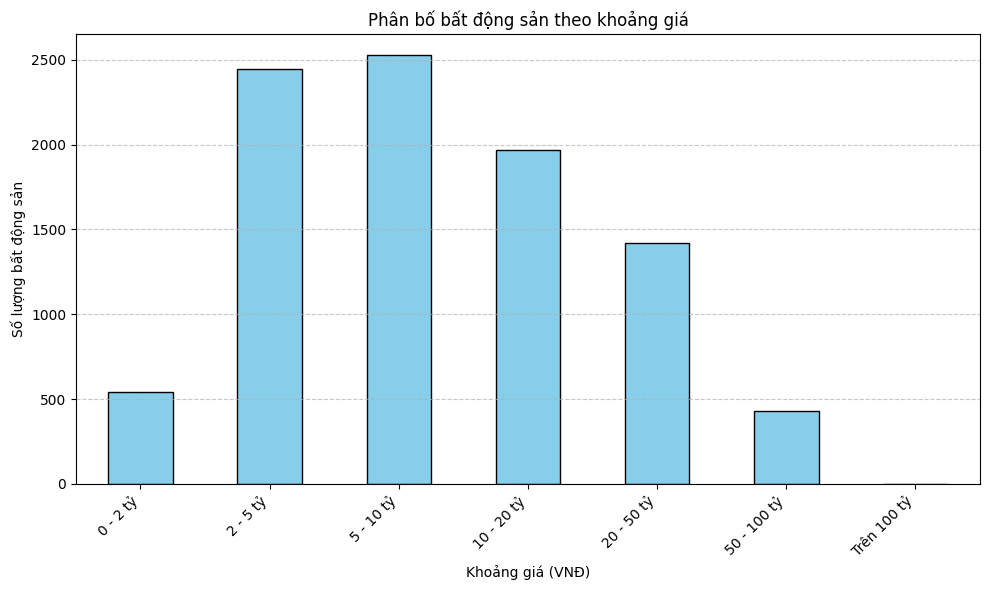

In [7]:
# Định nghĩa các khoảng giá và gắn nhãn
bins = [0, 2, 5, 10, 20, 50, 100, float('inf')]  # Các khoảng giá (tính bằng đồng)
labels = [
    "0 - 2 tỷ", "2 - 5 tỷ", "5 - 10 tỷ", "10 - 20 tỷ", 
    "20 - 50 tỷ", "50 - 100 tỷ", "Trên 100 tỷ"
]

# Phân loại giá trị
df["Price Range"] = pd.cut(df["Price"], bins=bins, labels=labels, right=False)

# Đếm số lượng bất động sản thuộc mỗi khoảng
price_distribution = df["Price Range"].value_counts(sort=False)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
price_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Phân bố bất động sản theo khoảng giá")
plt.xlabel("Khoảng giá (VNĐ)")
plt.ylabel("Số lượng bất động sản")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Nhận xét:**
- Dữ liệu cho thấy phần đông các bất động sản có giá trị từ trung bình đến cao cấp, cụ thể:
    - Các bất động sản tập trung nhiều nhất ở khoảng giá từ 2 - 10 tỷ, cho thấy các thị trường tập trung phần lớn vào tầng lớp trung lưu, nơi đang có sự mở rộng nhanh tại thành phố Hồ Chí Minh nhờ sự phát triển kinh tế mạnh mẽ vào nhiều năm trở lại đây.
    - Sự phân bổ các bất động sản có phần giảm dần ở phân khúc cao hơn 10 tỷ, nhưng vẫn ở mức cao cho thấy tầng lớp thượng lưu tai thành phố Hồ Chí Minh cũng là nhóm khách hàng mà thị trường đang dần hướng tới.
- Số liệu về các bất động sản thuộc mức giá trị thấp và siêu cao chỉ chiếm thiểu số
    - Các bất động sản thuộc phân khúc thấp chiếm phần ít nhất khi chỉ có hơn 500 bất động sản được rao bán, điều này cho thấy giá đất đai và chi phí xây dựng cao khiến việc cung cấp một bất động sản có giá trị thấp ngày càng xa vời và thành phố đang thiếu các chính sách hỗ trợ để những người có thu nhập phổ thông có khả năng có nhà tại thành phố.
    - Mặc dù các bất động sản có giá siêu cao chỉ chiếm số ít nhưng lại cao hơn khu vực bất động sản giá thấp, cho thấy thị trường này vẫn rất tìm năng đối với các chủ đầu tư bất động sản.


*Ghi chú: Dữ liệu được thu thập từ 27/09/24 đến 31/10/24 tại trang web batdongsan.com*

### 2. Thị phần bất động sản của các nhóm bất động sản

In [8]:
# Xử lý dữ liệu trước khi vẽ biểu đồ 
# Tạo cột "Loại chủ đầu tư" để phân nhóm
df["Developer"] = df["Developer"].str.lower()
df["Type of Developer"] = df["Developer"].apply(
    lambda x: "công ty" if x != "cá nhân/môi giới" else "cá nhân/môi giới"
)


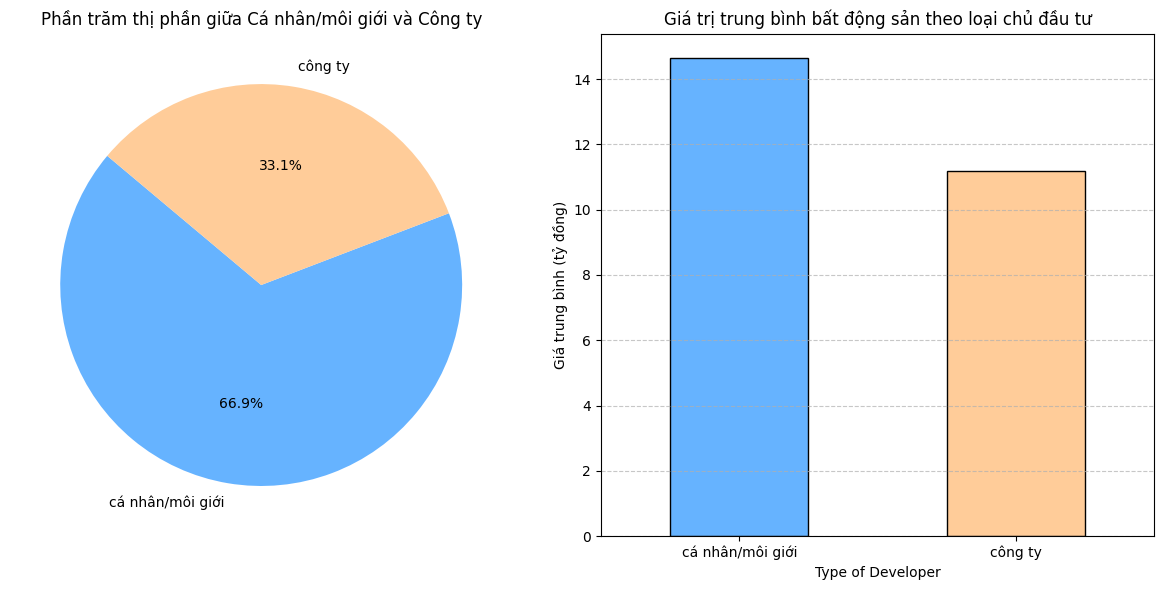

In [9]:

# 1. Tính phần trăm thị phần
market_share = df["Type of Developer"].value_counts(normalize=True) * 100

# 2. Tính giá trị trung bình và vẽ biểu đồ cột
avg_price = df.groupby("Type of Developer")["Price"].mean()

# Vẽ hai biểu đồ (thị phần và giá trị trung bình) 
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Biểu đồ tròn thị phần (biểu đồ 1)
axes[0].pie(
    market_share, 
    labels=market_share.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=["#66b3ff", "#ffcc99"]
)
axes[0].set_title("Phần trăm thị phần giữa Cá nhân/môi giới và Công ty")

# Biểu đồ cột giá trị trung bình (biểu đồ 2)
avg_price.plot(
    kind="bar", 
    color=["#66b3ff", "#ffcc99"], 
    edgecolor="black", 
    ax=axes[1]
)
axes[1].set_title("Giá trị trung bình bất động sản theo loại chủ đầu tư")
axes[1].set_ylabel("Giá trung bình (tỷ đồng)")
axes[1].grid(axis="y", linestyle="--", alpha=0.7)
axes[1].set_xticklabels(avg_price.index, rotation=0)

plt.tight_layout()
plt.show()


**Nhận xét:**
- Dữ liệu thống kê được phần lớn các bất động sản được rao bán là thuộc quản lý tư nhân hoặc môi giới:
    - Điều này không đồng nghĩa với việc số lượng bất động sản thực tế trên thị trường chiếm số đông ở cá nhân và môi giới, vì các công ty/tập đoàn bất động sản lớn thường rao bán trên nhiều kênh khác nhau mà chủ yếu là trên trang web chính thức của họ, do đó số liệu trên sàn tập trung này sẽ không nhiều bằng cá nhân và môi giới hay nói cách khác các sàn bất động sản tập trung không phải là kênh chính của các tập đoàn lớn
    - Đồng nghĩa với việc các sàn online tập trung như batdongsan.com là kênh chính của các nhà bất động sản "cá nhân/môi giới"

- Giá trị trung bình của các động sản cá nhân cao hơn rất nhiều (gần gấp đôi) so với các bất động sản thuộc diện công ty/tập đoàn bất động sản.
    - Các công ty/tập đoàn bất động sản thường hướng tới việc phục vụ cho nhu cầu số đông của các cá nhân nhân trên thị trường, do đó các bất động sản của họ thưòng có mức giá được cho là dễ tiếp cận hơn cho toàn thể dân cư so với các bất động sản cá nhân.
    - Các cá nhân/môi giới có giá trị trung bình của các bất động sản cao hơn có thể do sự cấu thành của nhiều lý do:
        - Khác với các bất động sản công ty/tập đoàn thường cố định theo mức giá đã được đề ra, các bất động sản cá nhân thường phải thông qua thương lượng để chốt được mức giá hợp lý, do đó các cá nhân thường đẩy giá cao hơn so với mức giá trị chính xác của BDS dẫn tới mức giá trung bình trên sàn thương mại cao hơn.
        - Các biệt thự các mức giá trị cao thường được rao bán dưới dạng cá nhân/môi giới, do đó nó cũng góp phần làm tăng mức giá trung bình của nhóm BDS này.

*Ghi chú: Dữ liệu được thu thập từ 27/09/24 đến 31/10/24 tại trang web batdongsan.com*

### 3. Thị phần BDS của thành phần các công ty BDS

In [10]:
def handle_name_of_developers(value):
    try:
        # Thay thế "Công ty" thành "CT" và "Cổ phần" thành "CP"
        value = value.replace("công ty", "CT").replace("cổ phần", "CP")
        return value
    except:
        return value


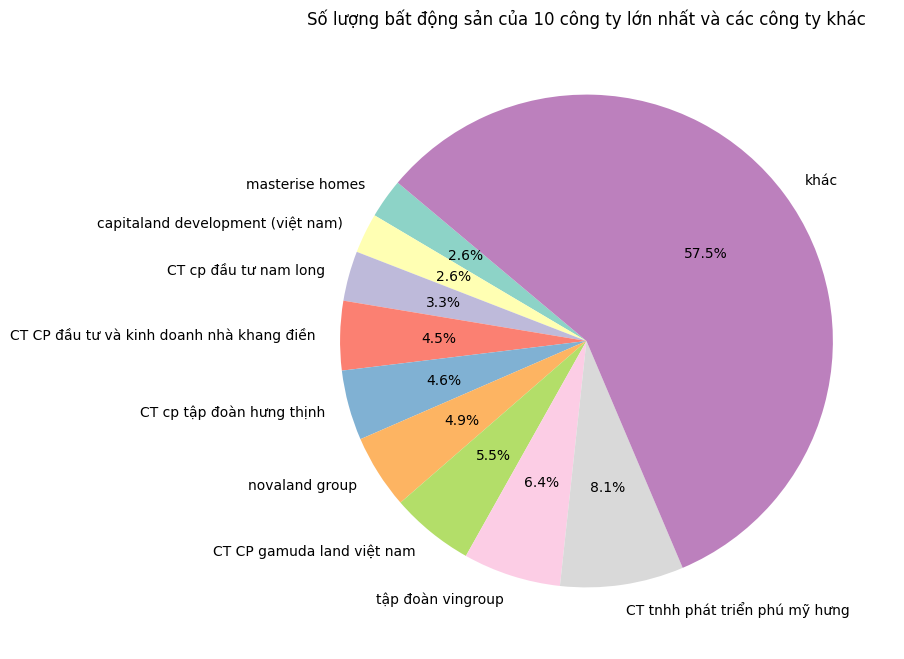

In [11]:

# 3. Phân tích các công ty
company_data = df[df["Type of Developer"] == "công ty"].copy()

company_data["Developer"] = company_data["Developer"].apply(handle_name_of_developers)

# Chuyển các chủ đầu tư có tên "đang cập nhật" vào nhóm "Khác"
company_data.loc[company_data["Developer"] == "đang cập nhật", "Developer"] = "khác"

# Đếm số lượng bất động sản của từng công ty sau khi xử lý
top_companies_updated = company_data["Developer"].value_counts()

# Đếm số lượng chủ đầu tư duy nhất
num_developers = company_data["Developer"].nunique()

# Tách 10 công ty lớn nhất (sau khi xử lý) và gộp các công ty khác
top_10_updated = top_companies_updated[:10]
others_updated = top_companies_updated[10:].sum()
top_10_updated["khác"] += others_updated

# Sắp xếp lại dữ liệu trước khi vẽ
top_10_updated = top_10_updated.sort_values(ascending=True)

# Vẽ lại biểu đồ tròn sau khi xử lý
plt.figure(figsize=(8, 8))
plt.pie(
    top_10_updated, 
    labels=top_10_updated.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=sns.color_palette("Set3")
)

plt.title("Số lượng bất động sản của 10 công ty lớn nhất và các công ty khác")
plt.show()

In [12]:
numer_of_deverlopers = company_data["Developer"].nunique()
print (f"Số lượng các công ty/tập đoàn BDS: {numer_of_deverlopers}")

Số lượng các công ty/tập đoàn BDS: 199


**Nhận xét:**
- Dựa vào dữ liệu ta thấy rằng thị phần BDS không phân tán tập trung vào các tập đoàn lớn mà phân tán rộng khắp cho các công ty và tập đoàn
    - Có đến 199 công ty/tập đoàn BDS khác nhau trong tập dữ liệu thu thập được
    - Có hơn 57% các bất động sản thuộc các công ty/tập đoàn vừa và nhỏ
- Trong các công ty/tập đoàn BDS lớn thì Phú Mỹ Hưng, Gamuda Land, VinGroup, Novaland Group và Tập Đoàn Hưng Thịnh là các tập đoàn lớn thâu tóm số lượng lớn các bất động sản (chiếm khoảng 25% thị phần các bất động sản công ty/tập đoàn)
    - Phú Mỹ Hưng là công ty top 1 với 8.1% thị phần
    - VinGroup và Gamuda Land lần lượt chiếm vị trí thứ 2 và 3 với chỉ số 6.6% và 5.5%
    - Novaland Group và Tập Đoàn Hưng Thịnh đang mất dần thị phần qua nhiều biến cố với 4.9% và 4.6% lần lượt đứng thứ 4 và 5 


*Ghi chú: Dữ liệu được thu thập từ 27/09/24 đến 31/10/24 tại trang web batdongsan.com*

## III. Sự liên hệ về giá và diện tích BDS tại thành phố Hồ Chí Minh

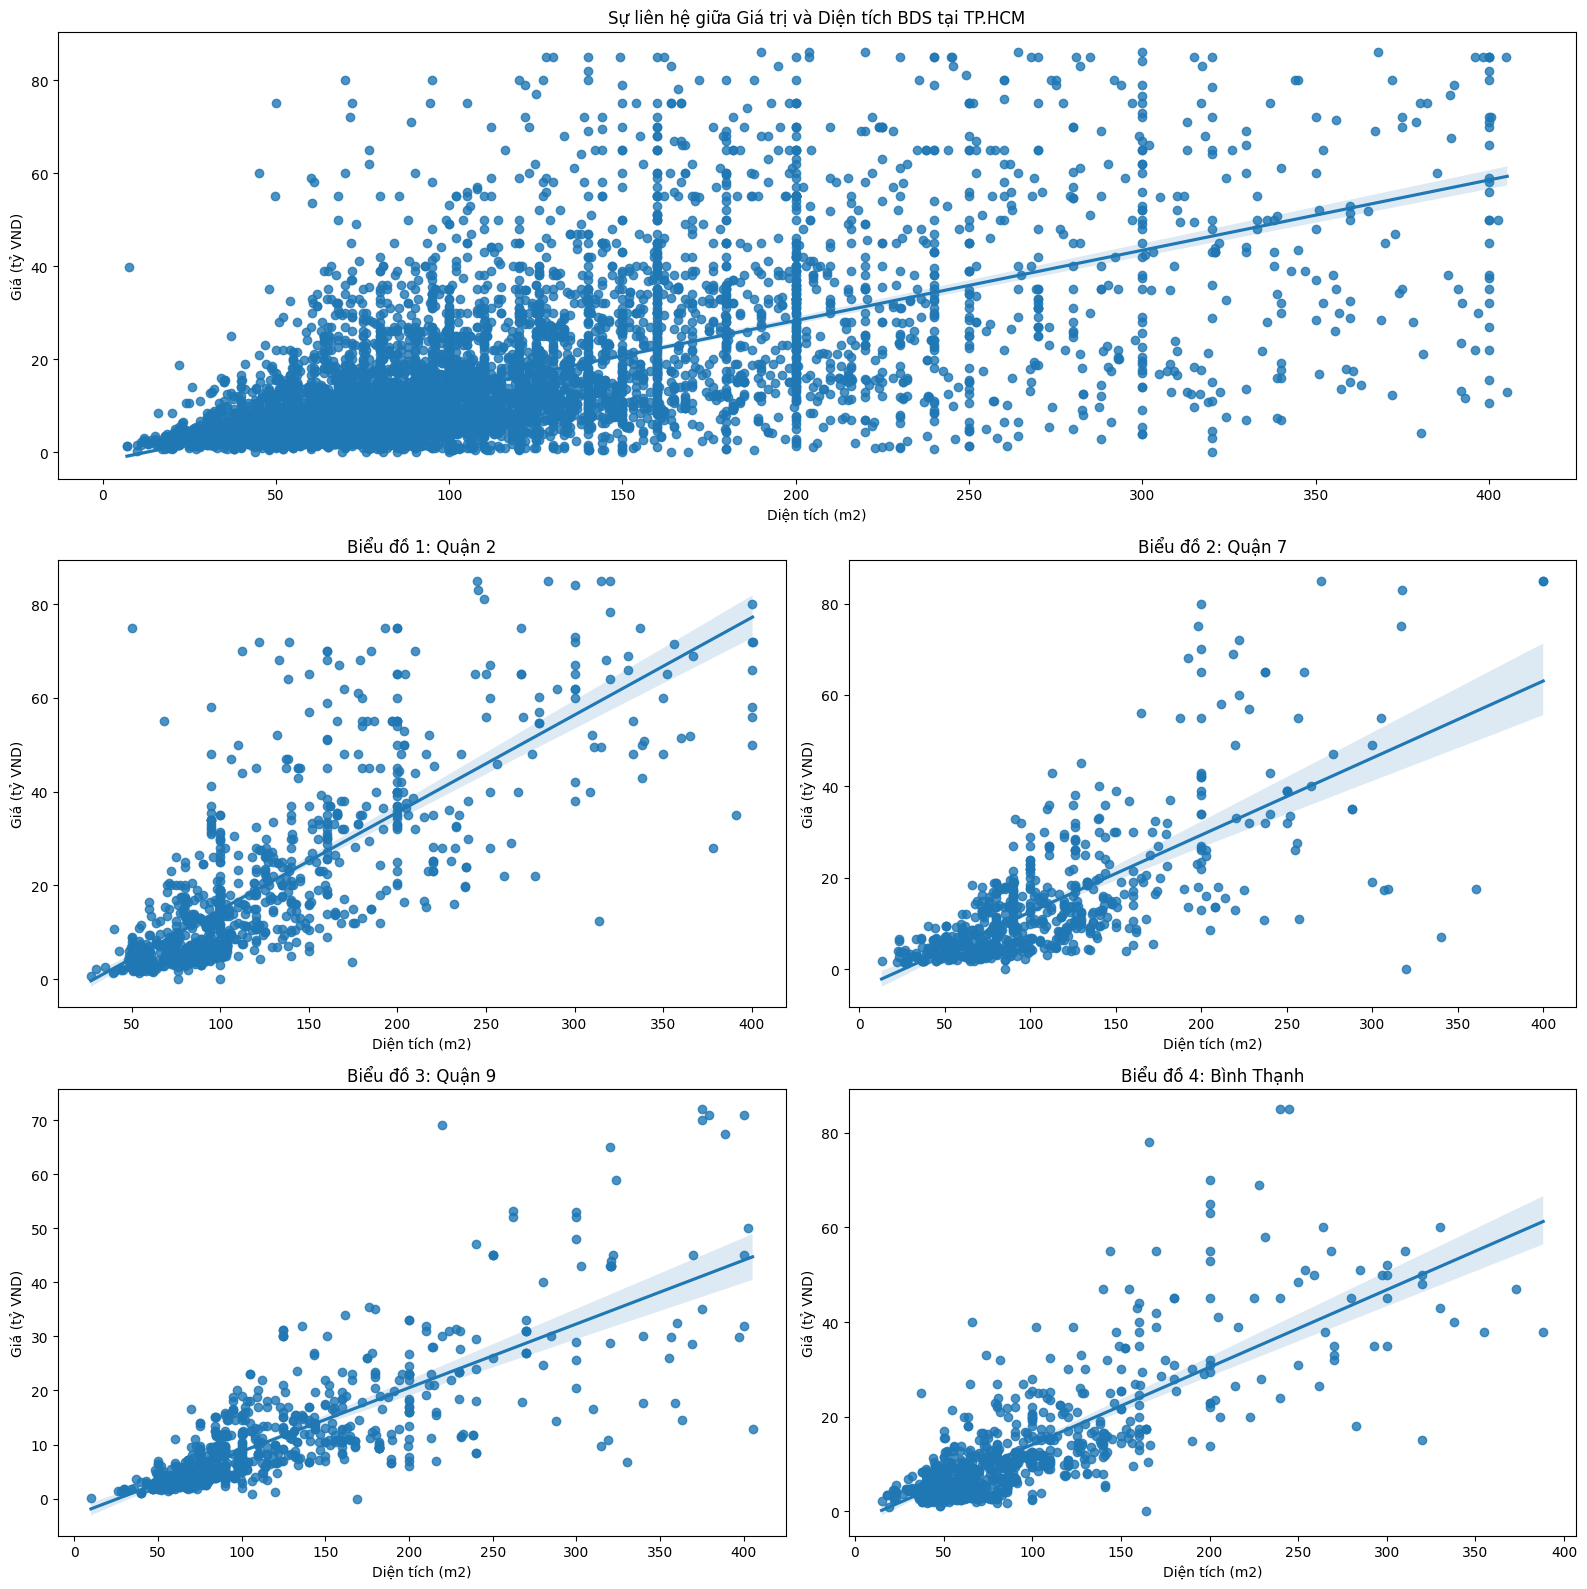

In [13]:
# Rút trích dữ liệu của một số quận để Visualization 
district_2 = df[df["District"] == "quận 2"]
district_7 = df[df["District"] == "quận 7"]
district_9 = df[df["District"] == "quận 9"]
district_BinhThanh = df[df["District"] == "bình thạnh"]


datasets = [district_2, district_7, district_9, district_BinhThanh]
district_names = ["Quận 2", "Quận 7", "Quận 9", "Bình Thạnh"]

# Tạo GridSpec để quản lý bố cục
fig = plt.figure(figsize=(16, 16))
gs = GridSpec(3, 2, figure=fig)  # 3 hàng, 2 cột

# Biểu đồ tổng thể (ở dòng đầu tiên, chiếm cả hàng)
ax_total = fig.add_subplot(gs[0, :])  # Chiếm toàn bộ dòng đầu
sns.regplot(data=df, x="Area", y="Price", ax=ax_total)
ax_total.set_title('Sự liên hệ giữa Giá trị và Diện tích BDS tại TP.HCM')
ax_total.set_xlabel('Diện tích (m2)')
ax_total.set_ylabel('Giá (tỷ VND)')

# Biểu đồ cho từng quận (ở các dòng sau)
for i, (data, name) in enumerate(zip(datasets, district_names)):
    row, col = divmod(i, 2)  # Tính hàng và cột
    ax = fig.add_subplot(gs[row + 1, col])  # Bắt đầu từ dòng thứ 2
    sns.regplot(data=data, x="Area", y="Price", ax=ax)
    ax.set_title(f'Biểu đồ {i + 1}: {name}')
    ax.set_xlabel('Diện tích (m2)')
    ax.set_ylabel('Giá (tỷ VND)')

# Tinh chỉnh bố cục
plt.tight_layout()
plt.show()



**Nhận xét:**
- Nhìn chung thuộc tính giá và diện tích có một sự tương quan thuận khá yếu
    - Điều này cho thấy ngoài diện tích thì còn nhiều yếu tố khác có ảnh hưởng đến mức giá của BDS có thể nhắc đến như: vị trí, tiện ích đi kèm,...

*Ghi chú: Dữ liệu được thu thập từ 27/09/24 đến 31/10/24 tại trang web batdongsan.com*

# C. Hỏi các câu hỏi có ý nghĩa

## I. Cần bao nhiêu tiền để sở hữu bất động sản tại thành phố Hồ Chí Minh?

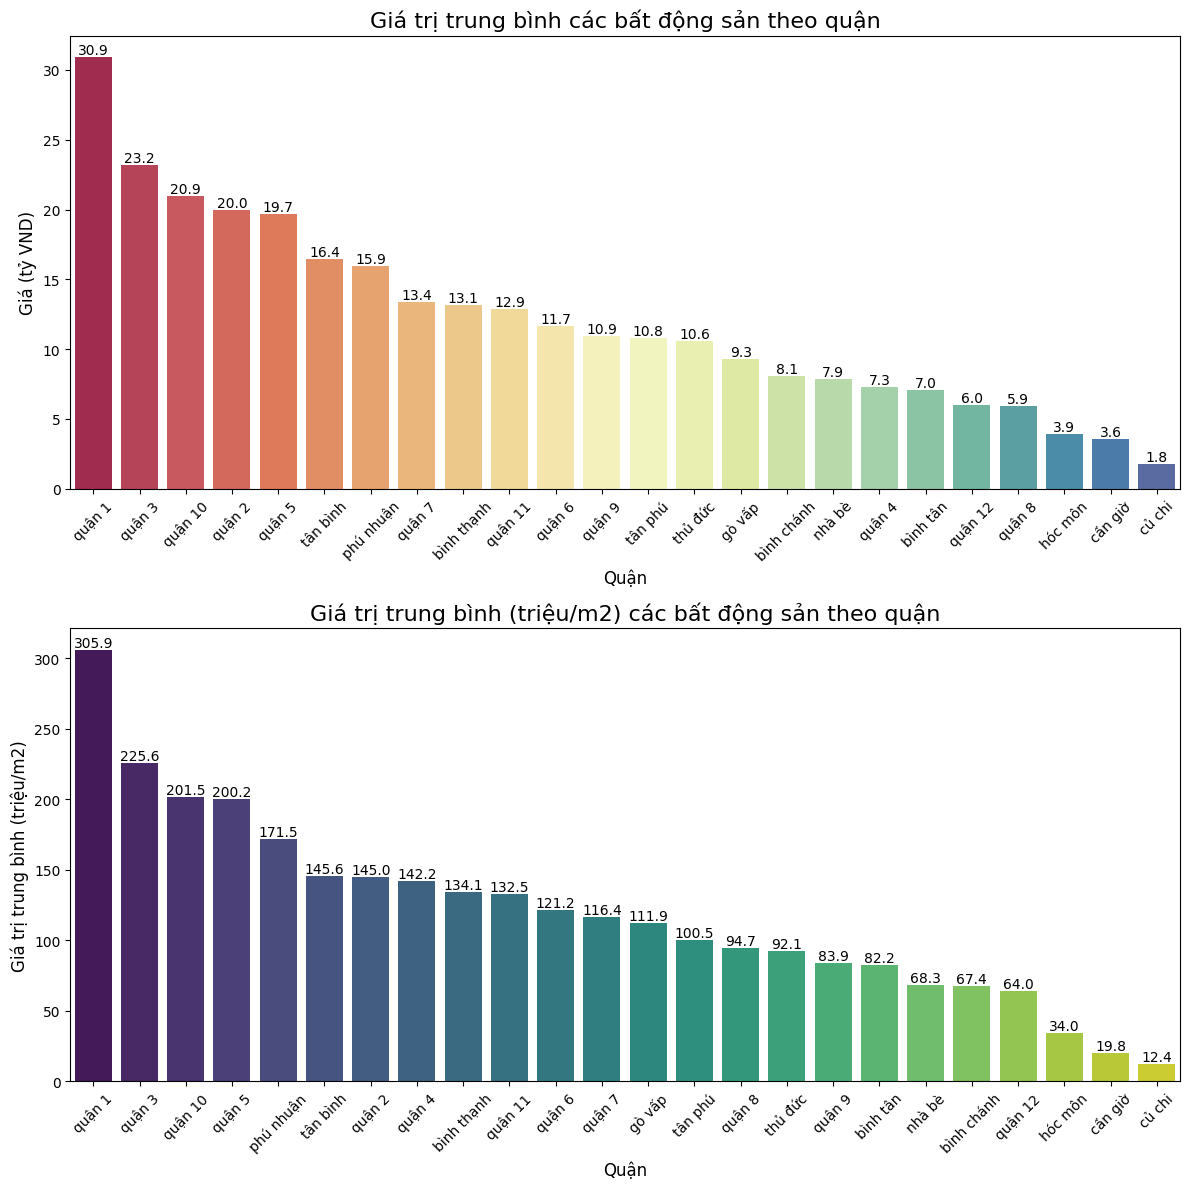

In [14]:
# Tính giá trị trung bình của Giá theo quận
avg_price_by_district = df.groupby("District")["Price"].mean().reset_index()

# Sắp xếp giá trị trung bình của Giá theo quận giảm dần
avg_price_by_district = avg_price_by_district.sort_values("Price", ascending=False)

# Tính giá trị trung bình của cột "Triệu/m2" theo từng quận
avg_price_per_m2_by_district = df.groupby("District")["Million/m2"].mean().reset_index()

# Sắp xếp giá trị trung bình của Triệu/m2 theo quận giảm dần
avg_price_per_m2_by_district = avg_price_per_m2_by_district.sort_values("Million/m2", ascending=False)

# Tạo một frame với 2 biểu đồ (1 trên, 1 dưới)
fig, ax = plt.subplots(2, 1, figsize=(12, 12))  # 2 hàng, 1 cột

# Vẽ biểu đồ cột cho "Giá" trong subplot đầu tiên
sns.barplot(data=avg_price_by_district, x="District", y="Price", ax=ax[0], palette="Spectral", hue="District", legend=False)
ax[0].set_title('Giá trị trung bình các bất động sản theo quận', fontsize=16)
ax[0].set_xlabel('Quận', fontsize=12)
ax[0].set_ylabel('Giá (tỷ VND)', fontsize=12)
ax[0].tick_params(axis='x', rotation=45)

# Ghi giá trị lên các cột ở biểu đồ đầu tiên
for container in ax[0].containers:
    ax[0].bar_label(container, fmt="%.1f", label_type="edge", fontsize=10)

# Vẽ biểu đồ cột cho "Triệu/m2" trong subplot thứ hai
sns.barplot(data=avg_price_per_m2_by_district, x="District", y="Million/m2", ax=ax[1], palette="viridis", hue="District", legend=False)
ax[1].set_title('Giá trị trung bình (triệu/m2) các bất động sản theo quận', fontsize=16)
ax[1].set_xlabel('Quận', fontsize=12)
ax[1].set_ylabel('Giá trị trung bình (triệu/m2)', fontsize=12)
ax[1].tick_params(axis='x', rotation=45)

# Ghi giá trị lên các cột ở biểu đồ thứ hai
for container in ax[1].containers:
    ax[1].bar_label(container, fmt="%.1f", label_type="edge", fontsize=10)

# Tinh chỉnh khoảng cách giữa các biểu đồ
plt.tight_layout()
plt.show()


**Nhận xét:**

- **1. Mức giá trung bình (tính theo tổng giá trị):**
    - Quận 3 và Quận 1 là hai quận có giá trung bình cao nhất, lần lượt là 30.9 tỷ và 23.2 tỷ.
    - Các khu vực có giá trung bình thấp nhất là Cần Giờ (3.6 tỷ), Củ Chi (1.8 tỷ), và Hóc Môn (3.9 tỷ).
    - Như vậy, để sở hữu một bất động sản tại TP.HCM, bạn cần trung bình từ 1.8 tỷ đến gần 30.9 tỷ, tùy thuộc vào quận.
- **2. Mức giá trung bình (tính theo triệu/m²):**
    - Quận 1 có mức giá trên mỗi mét vuông cao nhất: 305.9 triệu/m², gần gấp đôi nhiều khu vực khác.
    - Các quận như Quận 3 (225.6 triệu/m²) và Quận 10 (201.5 triệu/m²) cũng nằm trong nhóm đắt đỏ.
    - Các khu vực xa trung tâm như Cần Giờ (19.8 triệu/m²) và Củ Chi (12.4 triệu/m²) có giá rẻ hơn nhiều.
    - Vì vậy, bạn cần chuẩn bị từ 10 triệu đến gần 300 triệu/m², tùy thuộc vào vị trí bất động sản.
- **3. Nhận xét tổng quan:**
    - Khu vực trung tâm (Quận 1, Quận 3): Cần ngân sách cao, với mức giá bất động sản trung bình từ 20-30 tỷ và giá đất trung bình từ 200 - 300 triệu/m².
    - Khu vực cận trung tâm (Bình Thạnh, Quận 2, Quận 10): Cần ngân sách từ 13-20 tỷ, với mức giá đất dao động từ 130-200 triệu/m².
    - Khu vực ngoại thành (Củ Chi, Cần Giờ): Đây là những lựa chọn phù hợp với ngân sách thấp hơn, từ 2-10 tỷ, và giá đất chỉ khoảng 10-20 triệu/m².
- **4. Câu trả lời tổng hợp:**
    - Ngân sách tối thiểu: Khoảng 2 tỷ đồng cho một bất động sản tại các quận ngoại thành như Cần Giờ hoặc Củ Chi.
    - Ngân sách trung bình cho khu vực trung tâm: Từ 15 tỷ đồng trở lên (hoặc hơn nếu là bất động sản lớn tại Quận 1, Quận 3).
    - Mức giá trung bình đất: Khoảng 150-300 triệu/m² cho trung tâm, và dưới 50 triệu/m² cho các khu vực xa trung tâm.
    - Nếu bạn là một người có tài chính không quá dư giả nhưng muốn ở một quận trung tâm, hãy lựa chọn quận 4 khi chỉ cách Quận 1 một cái cầu và giá trung bình chỉ từ 7.3 tỷ cho một bất động sản.

## II. Quận nào có diện tích nhà trung bình lớn nhất nhưng giá trung bình lại thấp?

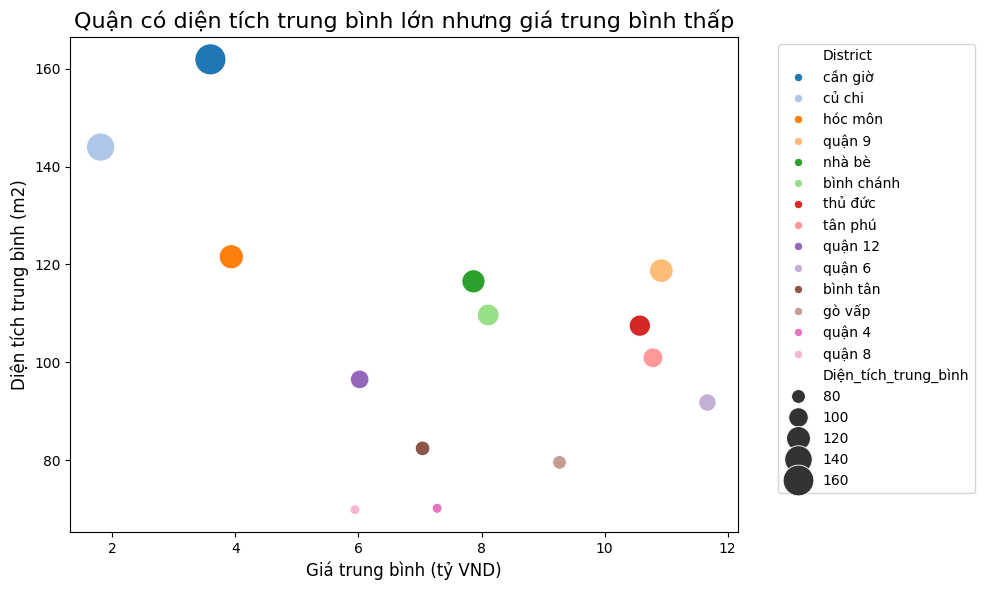

In [30]:
# Tính diện tích trung bình và giá trung bình theo từng phường
avg_area_price_by_ward = df.groupby("District").agg(
    Diện_tích_trung_bình=("Area", "mean"),
    Giá_trung_bình=("Price", "mean")
).reset_index()

# Tính giá trị trung bình của toàn thành phố để làm ngưỡng so sánh
mean_price_city = avg_area_price_by_ward["Giá_trung_bình"].mean()

# Lọc các phường có giá trung bình thấp hơn mức trung bình của thành phố
low_price_wards = avg_area_price_by_ward[avg_area_price_by_ward["Giá_trung_bình"] < mean_price_city]

# Sắp xếp theo diện tích trung bình giảm dần
result = low_price_wards.sort_values("Diện_tích_trung_bình", ascending=False)

# Vẽ biểu đồ minh họa
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(data=result, x="Giá_trung_bình", y="Diện_tích_trung_bình", hue="District", size="Diện_tích_trung_bình", sizes=(50, 500), palette="tab20", ax=ax)
ax.set_title('Quận có diện tích trung bình lớn nhưng giá trung bình thấp', fontsize=16)
ax.set_xlabel('Giá trung bình (tỷ VND)', fontsize=12)
ax.set_ylabel('Diện tích trung bình (m2)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Nhận xét: 
**Quận Củ Chi có diện tích trung bình lớn thứ 2 nhưng lại có giá trung bình thấp nhất mặc dù có diện tích trung bình nhỏ hơn so với Quận Cần Giờ**

## III. Nhà phát triển nào đưa ra bất động sản đắt nhất ?

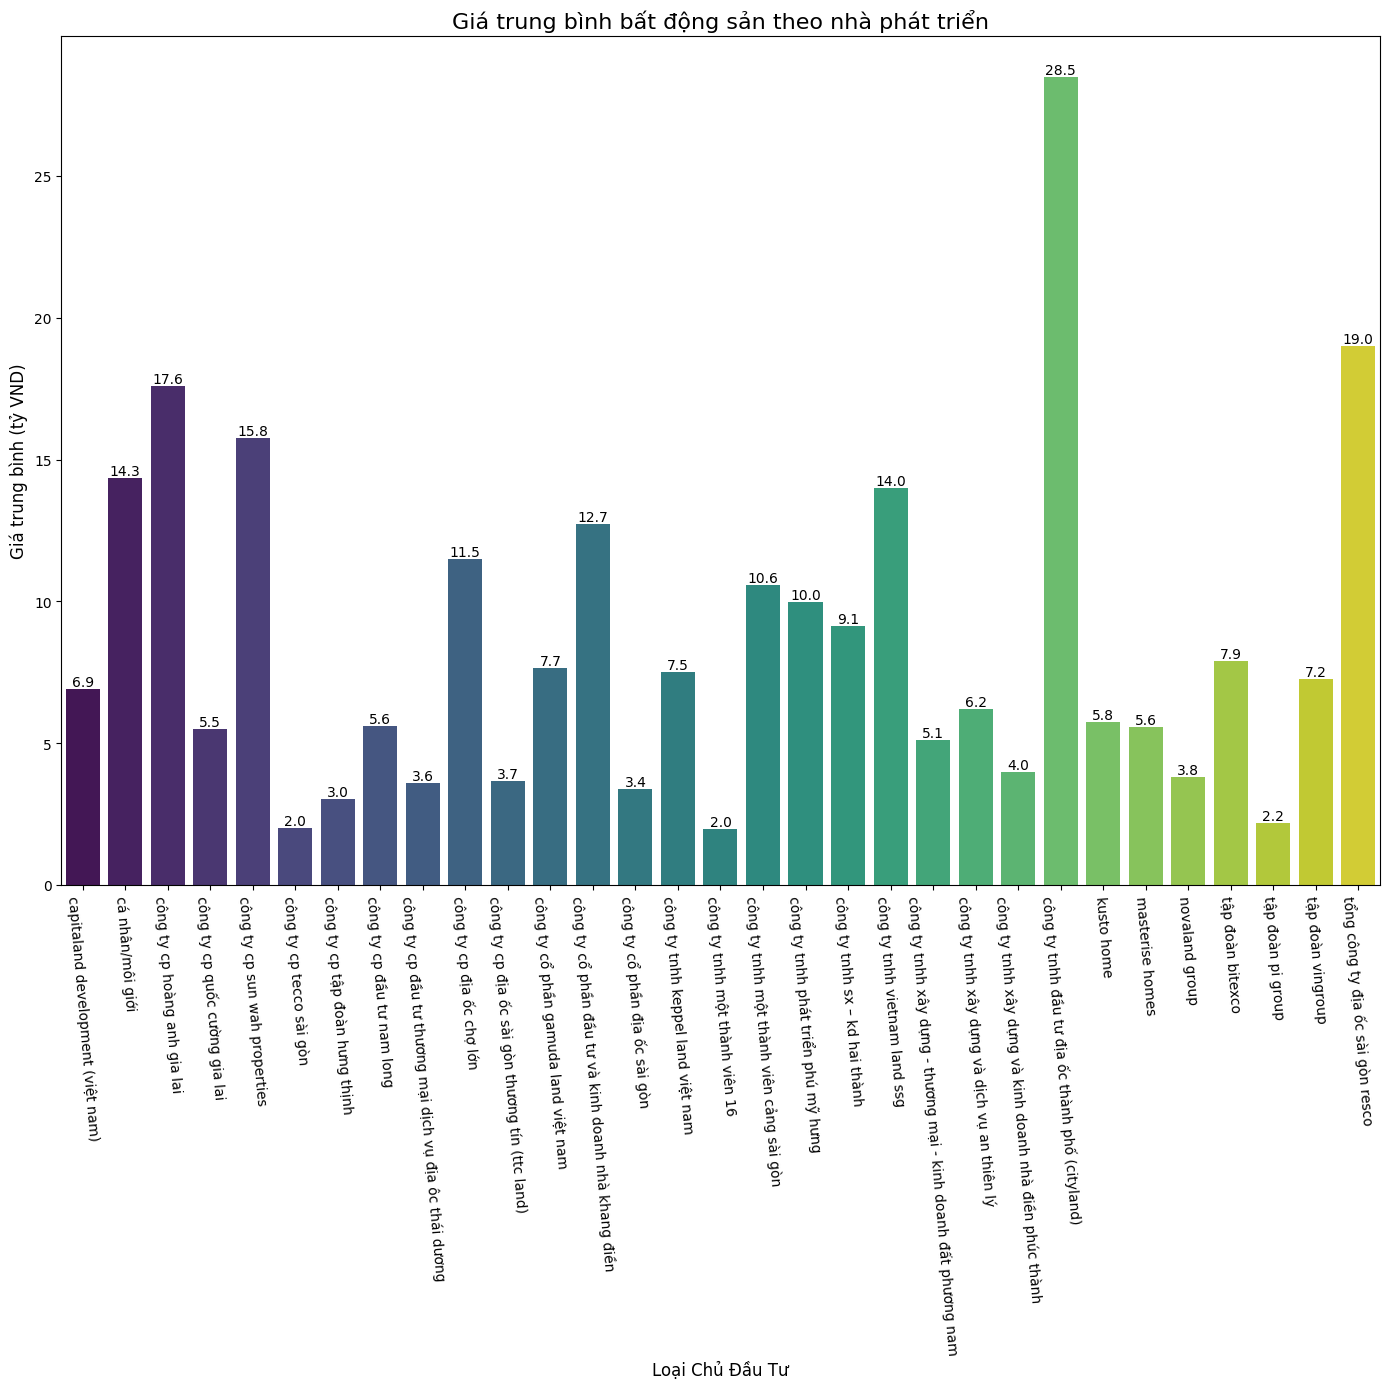

In [43]:
# Lấy 1 phẫn dữ liệu random
sampled_df = df.sample(n=200, random_state=42)

# Tính giá trung bình của bất động sản theo từng nhà phát triển
avg_price_by_developer = sampled_df.groupby("Developer")["Price"].mean().reset_index()

# Tìm nhà phát triển có giá trung bình cao nhất
max_price_developer = avg_price_by_developer.loc[avg_price_by_developer["Price"].idxmax()]

# Vẽ biểu đồ minh họa
fig, ax = plt.subplots(figsize=(14, 14))
sns.barplot(data=avg_price_by_developer, x="Developer", y="Price", hue="Developer", palette="viridis", ax=ax, dodge=False)

# Làm nổi bật nhà phát triển có giá cao nhất
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", label_type="edge", fontsize=10)
ax.set_title('Giá trung bình bất động sản theo nhà phát triển', fontsize=16)
ax.set_xlabel('Loại Chủ Đầu Tư', fontsize=12)
ax.set_ylabel('Giá trung bình (tỷ VND)', fontsize=12)

plt.xticks(rotation=275)
plt.tight_layout()
plt.show()

### Nhận xét: 
**Nhà phát triển có bất động sản đắt nhất: công ty tnhh đầu tư địa ốc thành phố (cityland) với giá trung bình 28.5 tỷ VND.**

## IV. Sự chênh lệch giữa giá bảng giá hiện tại và giá đề xuất trong từng quận

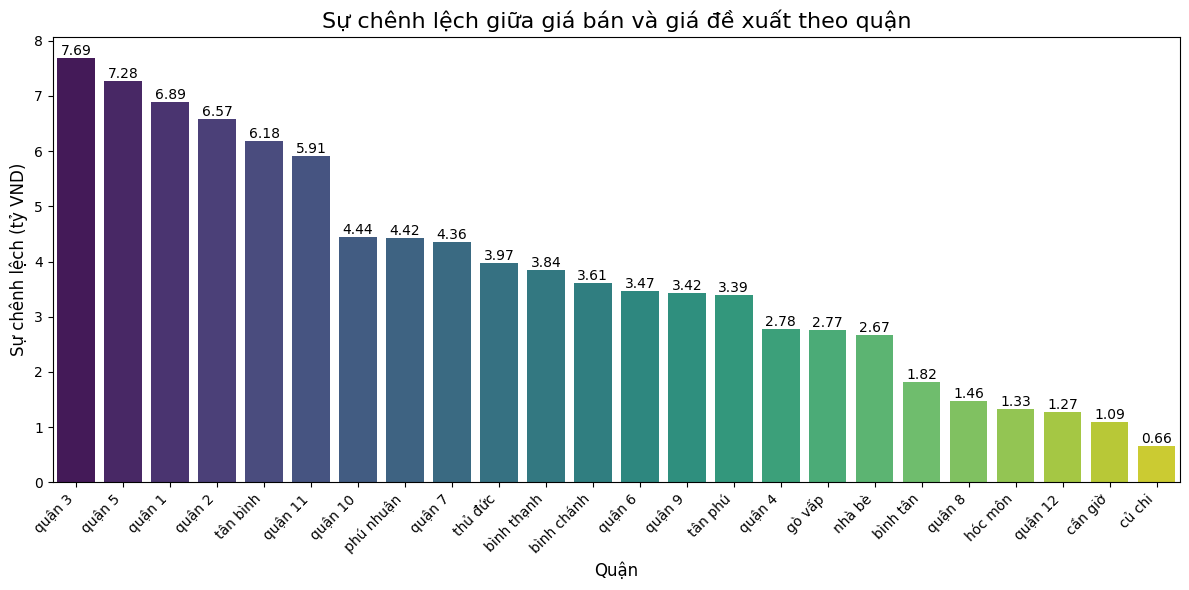

In [44]:
# Tính toán sự chênh lệch giữa Giá Bán và Giá Đề Xuất (tỷ VND)
df['Chênh lệch'] = df['Price'] - df['District Price']

# Tính giá trị trung bình của sự chênh lệch theo quận
avg_difference_by_district = df.groupby("District")["Chênh lệch"].mean().reset_index()

# Sắp xếp sự chênh lệch theo quận
avg_difference_by_district = avg_difference_by_district.sort_values("Chênh lệch", ascending=False)

# Vẽ biểu đồ sự chênh lệch giữa giá và giá đề xuất
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=avg_difference_by_district, x="District", y="Chênh lệch", hue="District", palette="viridis", ax=ax)

# Thêm nhãn giá trị trên các cột
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=10)

# Thiết lập tiêu đề và nhãn
ax.set_title('Sự chênh lệch giữa giá bán và giá đề xuất theo quận', fontsize=16)
ax.set_xlabel('Quận', fontsize=12)
ax.set_ylabel('Sự chênh lệch (tỷ VND)', fontsize=12)

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Nhận xét: 
- **Chênh lệch xảy ra cao ở các quận trung tâm điển hình là: Quận 1, Quận 3, Quận 2** 
- **Chênh lệch xảy ra thấp ở các quận ngoại thành là : hóc môn, củ chi, cần giờ**

## V. Tần suất bài đăng của bất động sản trên khu vực dựa trên với giá cả

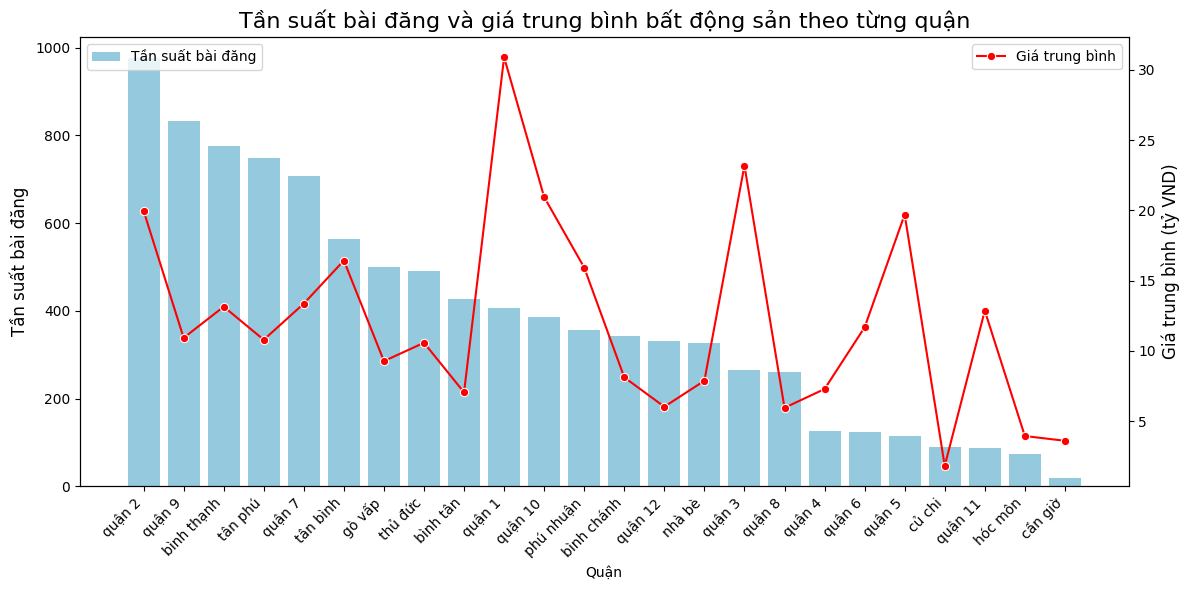

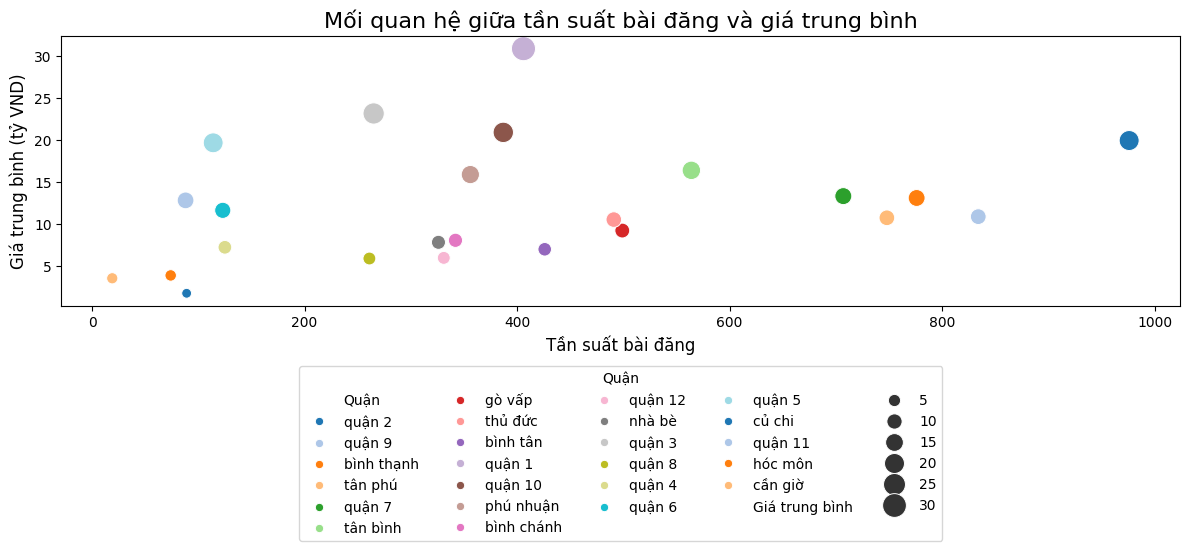

In [45]:
# Tính tần suất bài đăng theo khu vực
post_frequency = df["District"].value_counts().reset_index()
post_frequency.columns = ["Quận", "Tần suất bài đăng"]

# Tính giá trung bình theo khu vực
avg_price_by_area = df.groupby("District")["Price"].mean().reset_index()
avg_price_by_area.columns = ["Quận", "Giá trung bình"]

# Kết hợp dữ liệu
merged_data = pd.merge(post_frequency, avg_price_by_area, on="Quận")

# Vẽ biểu đồ cột đôi
fig, ax1 = plt.subplots(figsize=(12, 6))

# Biểu đồ cột cho tần suất bài đăng
sns.barplot(data=merged_data, x="Quận", y="Tần suất bài đăng", ax=ax1, color="skyblue", label="Tần suất bài đăng")
ax1.set_ylabel("Tần suất bài đăng", fontsize=12)
ax1.set_title("Tần suất bài đăng và giá trung bình bất động sản theo từng quận", fontsize=16)

# Thêm trục y phụ cho giá trung bình
ax2 = ax1.twinx()
sns.lineplot(data=merged_data, x="Quận", y="Giá trung bình", ax=ax2, color="red", label="Giá trung bình", marker="o")
ax2.set_ylabel("Giá trung bình (tỷ VND)", fontsize=12)

# Thêm chú thích
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Biểu đồ phân tán
fig, ax = plt.subplots(figsize=(12, 6))
sns.scatterplot(data=merged_data, x="Tần suất bài đăng", y="Giá trung bình", hue="Quận", size="Giá trung bình", sizes=(50, 300), palette="tab20", ax=ax)
ax.set_title("Mối quan hệ giữa tần suất bài đăng và giá trung bình", fontsize=16)
ax.set_xlabel("Tần suất bài đăng", fontsize=12)
ax.set_ylabel("Giá trung bình (tỷ VND)", fontsize=12)

ax.legend(
    bbox_to_anchor=(0.5, -0.2), 
    loc='upper center',          
    ncol=5,                      
    title="Quận",                
    fontsize=10                  
)
plt.tight_layout()
plt.show()


### Nhận xét: 
**Giá và Tần suất đăng bài không hoàn toàn tỷ lệ thuận**

## VI. Số lượng phòng cao hơn có đồng nghĩa với việc bất động sản có giá cao hơn không?

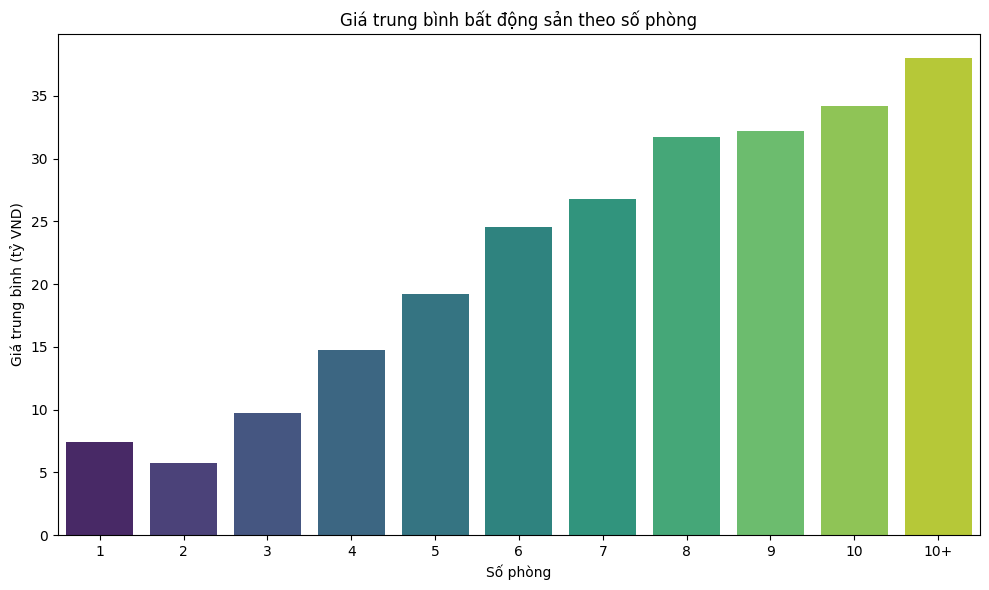

In [52]:
# Các khoảng số phòng
bins = [0, 1, 2, 3, 4, 5, 6, 7 , 8 , 9 , 10, float('inf')]
labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '10+']

# Thêm cột 'Khoảng số phòng' vào DataFrame
df['Khoảng số phòng'] = pd.cut(df['Bedrooms'], bins=bins, labels=labels, include_lowest=True)

# Tính giá trung bình của mỗi khoảng số phòng
room_avg_price = df.groupby('Khoảng số phòng', observed=False)['Price'].mean().reset_index()
room_avg_price.columns = ['Khoảng số phòng', 'Giá trung bình']


# Vẽ biểu đồ với seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=room_avg_price, x='Khoảng số phòng', y='Giá trung bình',hue="Khoảng số phòng", palette='viridis')
plt.title('Giá trung bình bất động sản theo số phòng')
plt.xlabel('Số phòng')
plt.ylabel('Giá trung bình (tỷ VND)')
plt.tight_layout()
plt.show()

### Nhận xét: 
 **Số phòng càng cao đồng nghĩa với việc bất động sản càng giá cao hơn**